In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import surp
from surp import gce_math as gcem

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


Pignatari et al. (2016) reports yields in terms of over production factors (OP), defined as
$$
{\rm OP} = \frac{M_{\rm ej, i}}{M_{\rm ej} Z_{i}^0}
$$
 i.e. the ratio between the mean ejected abundance composition and the initial composition of the star. 
 Since we are interested in net fractional yields, we can calculate these from the overproduction factor as follows
 $$
 Y_{X} = Z_{\rm ini} ({\rm OP} - 1) \frac{M_{\rm ej}}{M_{\rm ini}} = (Z_{\rm ej} - Z_{\rm ini}) \frac{M_{\rm ej}}{M_{\rm ini}}
 $$.
 
Thus from each nu-grid model, we need the OP factor, the initial and ejected mass, and the birth composition.

- P16: 10.26093/cds/vizier.22250024. Table 12. 
- R18 is available at DOI: 10.11570/18.0002

For P16, note that set 1.1 has Z=0.01, set 1.2 has Z=0.02.

In [3]:
path = surp.DATA_DIR + "/nugrid/"

In [4]:
p16_stars = pd.read_csv(path + "p16_stars.tsv", sep="\s+", comment="#")
p16_stars.set_index(["mass", "Z"], inplace=True)


In [5]:
p16_ops = pd.read_csv(path + "p16_yields.tsv", sep="\t", comment="#")

In [6]:
Zsun = pd.read_csv(path + "gn93.txt", comment="#", names=["element", "epsilon"])

In [7]:
Zsun["Z"] = gcem.eps_to_abundance(Zsun["epsilon"], Zsun["element"].values) * (1-0.2485 - 0.0179)



In [8]:
import vice

In [9]:
Zsun = Zsun.append({"element": "H", "Z": (1-0.2485 - 0.0179)}, ignore_index=True)
Zsun = Zsun.append({"element": "He", "Z": (0.2485)}, ignore_index=True)


/tmp/slurmtmp.26927194/ipykernel_10544/192375002.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Zsun = Zsun.append({"element": "H", "Z": (1-0.2485 - 0.0179)}, ignore_index=True)
/tmp/slurmtmp.26927194/ipykernel_10544/192375002.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Zsun = Zsun.append({"element": "He", "Z": (0.2485)}, ignore_index=True)


In [10]:
np.sum(Zsun.Z)

1.0001330388014773

In [11]:
p16_ops["Z"] = np.where(p16_ops.Set == 1.2, 0.02, 0.01)

In [12]:
p16_ops = p16_ops.melt(id_vars=["Sp", "Z"], value_vars=["OP1.65", "OP2", "OP3", "OP4", "OP5",], var_name="Mname", value_name="OP")


In [13]:
p16_ops["mass"] = p16_ops.Mname.str.extract(r"(\d?\.?\d+)")
p16_ops["mass"] = pd.to_numeric(p16_ops.mass)

In [14]:
p16 = p16_ops[p16_ops.mass < 8]

In [15]:
m_rem = [p16_stars.loc[r.mass, r.Z][0] for i, r in p16.iterrows()]

In [16]:
p16["M_rem"] = m_rem

In [17]:
Zsun.set_index("element", inplace=True)

In [68]:
p16["element"] = p16.Sp.str.strip()

In [69]:
Z0 = [Zsun.loc[r.element].Z for i, r in p16.iterrows()]

In [70]:
p16["Zini"] = Z0 * p16.Z / 0.0179

In [72]:
p16["yields"] = p16.Zini * (p16.OP - 1) * (1 - p16.M_rem/p16.mass)

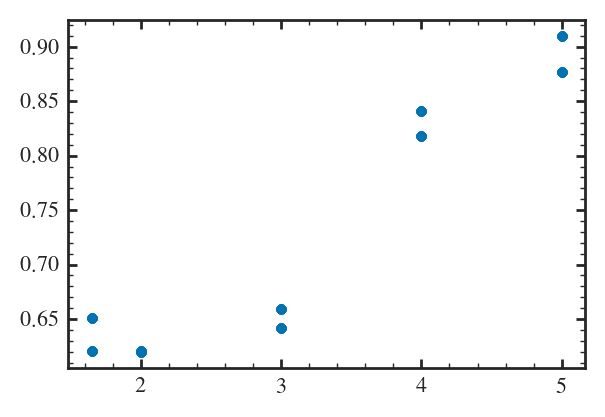

In [73]:
plt.scatter(p16.mass, p16.M_rem)

In [74]:
b19 = pd.read_csv(path + "/B19.txt", sep="\s+", skiprows=2, index_col=0)
b21 = pd.read_csv(path + "/B21.txt", sep="\s+", skiprows=2, index_col=0)

In [75]:
b19_ele = pd.DataFrame(columns=b19.columns)
for idx, row in b19.iterrows():
    ele, _ = idx.split("-")
    if ele in b19_ele.index:
        b19_ele.loc[ele] += row
    else:
        b19_ele = pd.concat([b19_ele, pd.DataFrame(row.to_dict(), index=[ele])])

In [76]:
b21_ele = pd.DataFrame(columns=b21.columns)
for idx, row in b21.iterrows():
    ele, _ = idx.split("-")
    if ele in b21_ele.index:
        b21_ele.loc[ele] += row
    else:
        b21_ele = pd.concat([b21_ele, pd.DataFrame(row.to_dict(), index=[ele])])

In [77]:
elements = "H, He, Li, B, C, N, O, F, Ne, Na, Mg, Al, Si, P, Pb, S, Cl, Ar, K, Ca, Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, Ga, Ge, As, Se, Br, Kr, Rb, Sr, Y, Zr, Nb, Mo, Ru, Rh, Pd, Ag, Cd, In, Sn, Sb, Te, I, Xe, Cs, Ba, La, Ce, Pr, Nd, Sm, Eu, Gd, Tb, Dy, Ho, Er, Tm, Yb, Lu, Hf, Ta, W, Re, Os, Ir, Pt, Au, Hg, Tl, Bi".split(", ")

In [111]:
raw = {}
yields = {}

for ele in elements:
    raw[ele] = pd.DataFrame()
    yields[ele] = pd.DataFrame()

a = pd.DataFrame()
with open(path + "/element_yield_table_MESAonly_fryer12_delay_total.txt") as file:
    skip = 6
    M = None
    M_ej = None
    for line in file:
        if skip > 0:
            skip -= 1
            continue
            
        if line[:7] == "H Table":
            s1, s2 = line[10:].split(",")
            M = float(s1[2:])
            Z = float(s2[2:-2])
            skip = 1
            continue
            
        if line[:8] == "H Mfinal":
            M_rem = float(line[10:])
            M_ej = M - M_rem
            skip = 1
            continue
            
        if M_ej is None:
            continue
        
        _, ele, y, x0, _ = line.split("&")

        y = float(y)
        x0 = float(x0)
        xf = y/M_ej
        y_net_fractional = (xf - x0) * M_ej/M
        ele = ele.strip()
        
        row = pd.DataFrame({"mass":M, "M_rem":M_rem, "Z":Z, "y":y, "x0": x0}, index=[0])
        raw[ele] = pd.concat([raw[ele], row], ignore_index=True)
        
        row = pd.DataFrame({"mass":M, "M_rem":M_rem, "Z":Z, "y":y, "yield": y_net_fractional, "x0": x0, "element": ele}, index=[0])
        a = pd.concat([a, row], ignore_index=True)

        
        row = pd.DataFrame({"mass":M, "Z":Z, "y":y_net_fractional}, index=[0])
        yields[ele] = pd.concat([yields[ele], row], ignore_index=True)

In [112]:

for ele in elements:
    raw[ele].set_index(["mass", "Z"], inplace=True)

In [80]:
# update the relevant models with B19 and B21
for ele in elements:
    b19r = b19_ele.loc[ele]
    b21r = b21_ele.loc[ele]
    for M, Z, b, key in [
        (2, 0.01, b19r, "m2z1m2"),
        (3, 0.01, b19r, "m3z1m2"),
        (2, 0.02, b19r, "m2z2m2"),
        (3, 0.02, b19r, "m3z2m2"),
        (2, 0.001, b21r, "m2z1m3-bigpoc"),
        (3, 0.001, b21r, "m3z1m3-bigpoc")
    ]:
        df = raw[ele]
        y = b[key]
        raw[ele].loc[(M, Z), :]["y"] = y

In [113]:
yields_old = {ele: df.copy() for ele, df in yields.items()}

In [114]:
for ele in elements:
    df = raw[ele]
    df["M"] = [a[0] for a in df.index]
    df["Z"] = [a[1] for a in df.index]
    M_ej = df.M - df.M_rem
    x_ej = df.y/M_ej
    y_net_frac = (x_ej - df.x0) * M_ej/df.M
    yields[ele]["yields"] = y_net_frac.values
    yields[ele] = yields[ele].set_index(["mass", "Z"])

In [115]:
p16_yields = {}
for ele in p16.Sp.unique():
    df = p16[p16.Sp == ele]
    p16_yields[ele.strip()] = df[["mass", "Z", "yields"]].set_index(["mass", "Z"])

In [116]:
cd ~/VICE/vice/yields/agb/pignatari16/

/users/PAS2232/aeyobd/VICE/vice/yields/agb/pignatari16


In [117]:
for ele, table in yields.items():
    filename = "%s.dat" % (ele.lower())
    df = table[table.mass < 8].sort_values(by=["mass", "Z"])
    df.to_csv(filename, sep="\t", index=False, header=False)

AttributeError: 'DataFrame' object has no attribute 'mass'

In [118]:
a["OP"] = a.y / ((a.mass -a.M_rem) * a.x0)
a["y2"] = (a.OP - 1) * a.x0 * (a.mass - a.M_rem) / a.mass
p16["element"] = p16.Sp

In [119]:

d1 = p16.set_index(["element", "Z", "mass"])
d2 = a.set_index(["element", "Z", "mass"])

In [123]:
raw["He"]

,,M_rem,y,x0,M,Z
mass,Z,,,,,
1.00,0.0200,0.5601,0.1292,0.2735,1.00,0.0200
1.65,0.0200,0.6510,0.2911,0.2735,1.65,0.0200
2.00,0.0200,0.6201,0.4056,0.2735,2.00,0.0200
3.00,0.0200,0.6420,0.7150,0.2735,3.00,0.0200
4.00,0.0200,0.8180,0.9663,0.2735,4.00,0.0200
5.00,0.0200,0.8768,1.3970,0.2735,5.00,0.0200
6.00,0.0200,0.9653,1.8170,0.2735,6.00,0.0200
7.00,0.0200,1.0660,2.2390,0.2735,7.00,0.0200
12.00,0.0200,1.6100,4.1110,0.2735,12.00,0.0200


In [120]:
for ele in p16.Sp.unique():
    if ele.strip() in raw.keys():
        print(ele)
        s1 = d1.xs(ele)
        s2 = d2.xs(ele)
        print("inital z rel", np.mean(s1.Zini / s2.x0))

        print("mean ratio ", np.mean(s1.yields / s2["yield"]))
        print("std error ", np.std((s1.yields - s2["yield"])))
        print("std rel error ", np.std((s1.yields - s2["yield"])/s2["yield"]))
        print("op method", np.mean(s2.y2/s2["yield"]))

        print()
    else:
        print(ele)

H
inital z rel 0.8611805084832216
mean ratio  0.87265744406354
std error  0.012381657788528396
std rel error  0.30847000720002665
op method 1.0

He
inital z rel 0.7735452299451233
mean ratio  0.7784934976340974
std error  0.00936543295007244
std rel error  0.2429511964891325
op method 1.0

C
inital z rel 1.0078072882108295
mean ratio  1.205346193732895
std error  0.00030043063418826903
std rel error  0.6497809726450853
op method 1.0

N
inital z rel 1.0079498921772374
mean ratio  0.9631252768700909
std error  0.0003331911477894907
std rel error  0.1251406646109858
op method 1.0

O
inital z rel 1.0074251902977145
mean ratio  1.1125571569440913
std error  4.169707106175842e-05
std rel error  0.37384380639438697
op method 0.9999999999999929

F
inital z rel 0.8382080427376707
mean ratio  0.8291530051586765
std error  8.633976611302276e-08
std rel error  0.024344092664791657
op method 1.0000000000000027

Ne
inital z rel 1.0098599997506028
mean ratio  1.0128888765788469
std error  3.974998104

In [106]:
for ele in p16_yields.keys():
    if ele in yields.keys():
        rel = (p16_yields[ele] / yields[ele]).yields
        print(np.std(rel), np.mean(rel))
    

0.4106810955187277 0.6578776817303214
0.5815709613061687 0.5230974408134539
0.83663744809097 1.6699476833527753
0.5861772740435804 1.2773005224526108
85.55275160644432 29.003198497396852
0.8810893682620334 1.4307690348105397
4.009537610964103 0.7812225098795996
2272.9162831980534 758.337631262707
0.773531205130269 0.4964475718809549
0.8666640235730904 0.8979430399272236
0.5612130769868449 0.3666303757332974
0.5529348954102918 0.4737031214404649
0.43180852717217977 0.3876163043965395
0.6897462388472403 0.4879386694986578
0.8019778544026661 0.9237929549662457
2.688541134528168 -0.6703282011904428
0.6729123263222505 0.7774549604125662
0.7714805685493613 0.5180848186142599
0.5158291698177466 0.13581908497557965
1.8270685096795216 -0.20757477943096933
0.49772859919921153 0.41459101487464756
1.4080393527081732 0.09582816237795264
0.4422272025776996 0.38965738929594956
5.082550658815984 -1.5190426093699796
0.9557646797497734 1.0151405234638777
5.55034449685153 -0.805787035922482
0.61512313929

In [107]:
gn93 = {ele: raw[ele].x0.iloc[0] / 0.02 * 0.0179 for ele in elements} # TODO go to primary source for this
# this is for Z=0.02
gn93["Tc"] = 0
gn93["Pm"] = 0

In [108]:
for idx, row in Zsun.iterrows():
    if row.element.lower() not in vice.solar_z.keys():
        continue
    print(row.element, row.Z, vice.solar_z(row.element), gn93[row.element])
    
    

AttributeError: 'Series' object has no attribute 'element'